In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk, os, re, string
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from cleantext import clean
from sklearn.model_selection import train_test_split

# from tensorflow.keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# load Dataset
df = pd.read_csv('mr.csv', header = 0, encoding='utf8')
df.tail()

,user,text,fullname,id,timestamp
7498,ianhryd,"Min, bales min",👽,886478646042435585,2017-07-16T06:52:33
7499,Stallonation,"@MyRepublicID dear admin, untuk di daerah Pasa...",Stallone Tjia,886478794038562816,2017-07-16T06:53:09
7500,b4ngda,@MyRepublicID keluhan gw cuman satu....gw gak ...,bangda,886480325727010817,2017-07-16T06:59:14
7501,Drant44,@MyRepublicID masih perbaikan kah?,Drant,886482211976790016,2017-07-16T07:06:44
7502,GibrunNodros,@MyRepublicID lemot lu,Gibran,886482370714402820,2017-07-16T07:07:21


In [3]:
df = df.drop(['user','fullname','id','timestamp'], axis = 1)

In [4]:
df['text'] = df['text'].astype('str') 

In [5]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positif'
    elif analysis.sentiment.polarity < 0:
        return 'Negatif'
    else:
        return 'Netral'

In [6]:
df["sentiment"] = df["text"].apply(lambda x : analyze_sentiment(x))
df.tail()

,text,sentiment
7498,"Min, bales min",Netral
7499,"@MyRepublicID dear admin, untuk di daerah Pasa...",Netral
7500,@MyRepublicID keluhan gw cuman satu....gw gak ...,Netral
7501,@MyRepublicID masih perbaikan kah?,Netral
7502,@MyRepublicID lemot lu,Netral


# Cleansing Data

In [7]:
def data(text):
    text = clean(text,
                 no_punct=True,
                 lower=True,
                 no_emoji=True,
                 normalize_whitespace=True
                )
    
    return text

In [8]:
# Remove mentions
regex_mentions = r"@[A-Za-z0-9_]+"
# Remove links
regex_links = r"https?://[A-Za-z0-9./]+"
# Remove some special characters
regex_special = r"[^A-Za-z0-9]+"
# Remove numbers 
regex_numbers = r"[0-9]+"
# Remove ordinals 
regex_ordinals = r"[0-9]+(?:st| st|nd| nd|rd| rd|th| th)"

In [9]:
# Remove mentions
df.text = df.text.apply(lambda x: re.sub(regex_mentions, " ", str(x).strip()))
# Remove links 
df.text = df.text.apply(lambda x: re.sub(regex_links, " ", str(x).strip()))
# Remove special characters
df.text = df.text.apply(lambda x: re.sub(regex_special, " ", str(x).strip()))
# Remove ordinals
df.text = df.text.apply(lambda x: re.sub(regex_ordinals, " ", str(x).strip()))
# Remove numbers 
df.text = df.text.apply(lambda x: re.sub(regex_numbers, " ", str(x).strip()))
# Clean tweets
df.text = df.text.apply(lambda x: data(x)) 

In [10]:
# data category one-hot-encoding
sentiment = pd.get_dummies(df.sentiment)
new = pd.concat([df, sentiment], axis=1)
new = new.drop(columns='sentiment')
new.tail()

,text,Negatif,Netral,Positif
7498,min bales min,0,1,0
7499,dear admin untuk di daerah pasar baru jakarta ...,0,1,0
7500,keluhan gw cuman satu gw gak langganan myrepub...,0,1,0
7501,masih perbaikan kah,0,1,0
7502,lemot lu,0,1,0


In [12]:
# change dataframe value to numpy array
X = new['text'].values
y = new[['Negatif', 'Netral', 'Positif']].values

In [13]:
# Split data into training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [14]:
# tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X_train) 
tokenizer.fit_on_texts(X_test)
 
S_train = tokenizer.texts_to_sequences(X_train)
S_test = tokenizer.texts_to_sequences(X_test)
 
P_train = pad_sequences(S_train) 
P_test = pad_sequences(S_test)

In [19]:
# model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy',)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          320000    
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 435,715
Trainable params: 435,715
Non-trainable params: 0
_________________________________________________________________


In [20]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.9200 and logs.get('val_accuracy') > 0.9200):
      self.model.stop_training = True
      print("\nHas Been Reached > 92% Accuracy!!!")
callbacks = myCallback()

In [21]:
# model fit
Hist = model.fit(P_train, y_train, epochs=50, 
                    validation_data=(P_test, y_test), verbose=2, callbacks=[callbacks], validation_steps=30)

Epoch 1/50
188/188 - 15s - loss: 0.5327 - accuracy: 0.8481 - val_loss: 0.3745 - val_accuracy: 0.8894 - 15s/epoch - 82ms/step
Epoch 2/50
188/188 - 11s - loss: 0.2870 - accuracy: 0.9005 - val_loss: 0.2550 - val_accuracy: 0.9194 - 11s/epoch - 58ms/step
Epoch 3/50

Has Been Reached > 92% Accuracy!!!
188/188 - 11s - loss: 0.1876 - accuracy: 0.9299 - val_loss: 0.2456 - val_accuracy: 0.9334 - 11s/epoch - 59ms/step


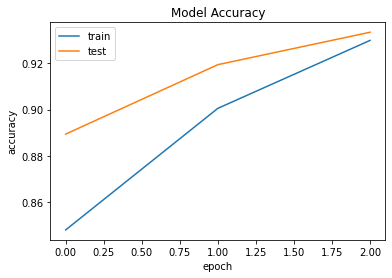

In [22]:
# plot of accuracy
import matplotlib.pyplot as plt
plt.plot(Hist.history['accuracy'])
plt.plot(Hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

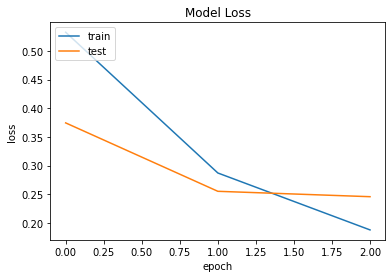

In [23]:
# plot of loss
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()